In [1]:
# System
import os

# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
SAVE_INFO = True

In [3]:
if (SAVE_INFO == True):
    DATA_DIR = 'Experiments/'
    EXPERIMENT_DIR = DATA_DIR + 'Self_attention+PE(sum)_0/'
    os.makedirs(EXPERIMENT_DIR)
    
READY_DIR = 'ready/with_PE/'

### посмотрим что мы имеем

## Разбиение датасета по дням и по клеткам в сетке

In [4]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 160
N_CELLS_VER = 200

In [5]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 160, 200])


In [6]:
# celled_data_RTL = torch.load("Data/RTL_features")
# print (celled_data_RTL.shape)

In [7]:
def show_one_day_image (tensor, day):
    plt.imshow (tensor[day].squeeze(0), cmap=plt.cm.afmhot_r)
    plt.colorbar()
    
def show_one_day_quakes (tensor, day):
    state = tensor[day].squeeze(0)
    print (state.shape)
    X = []
    Y = []
    M = []
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if (state[i][j] != 0):
                X.append(i)
                Y.append(j)
                M.append(state[i][j].item())
    print (X)
    print (Y)
    print (M)
    
    fig = plt.figure(figsize=(8, 10))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.axis([0, state.shape[0], 0, state.shape[1]])
    axes.scatter(X, Y, s=500, c=M, marker='.', cmap=plt.cm.Reds)
#     plt.colorbar()
    

torch.Size([160, 200])
[59, 70, 111, 119]
[71, 69, 135, 142]
[2.5, 2.5999999046325684, 3.700000047683716, 2.9000000953674316]


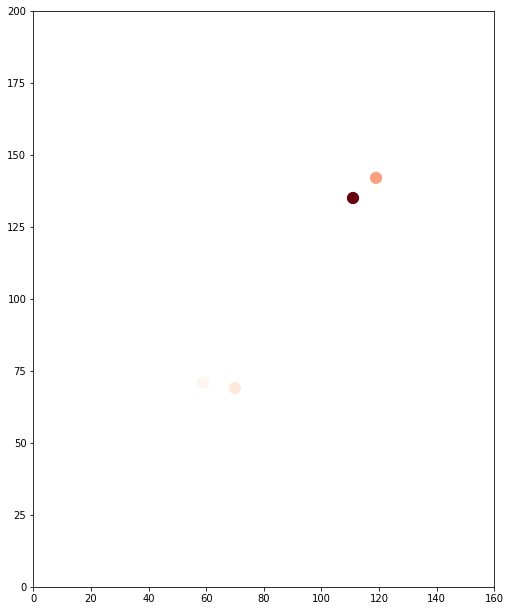

In [8]:
show_one_day_quakes (celled_data, 34)

# Обучение

In [9]:
DEVICE_ID = 6
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
# DEVICE = torch.device('cpu')
print (DEVICE)
# torch.cuda.set_device(DEVICE_ID)

cuda:6


In [10]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((     (input>threshold) .float() * target      ).float())
    FP = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    TN = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def my_TP_FN_FP_TN (input, target, threshold):
    matrix = np.zeros((2, 2))
    matrix[0, 0] = torch.sum ((     (input>threshold) .float() * target      ).float())
    matrix[1, 0] = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    matrix[0, 1] = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    matrix[1, 1] = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return matrix / np.sum(matrix)

### Создадим датасет
#### (Может не влезть в оперативку (надо ~ 12Gb))

In [11]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 3.5

In [12]:
mean_val = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

In [13]:
print (mean_val.shape)

torch.Size([1, 160, 200])


In [14]:
class EarthquakeDataset_RNN_Usual_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        accurate_pred = ((torch.sum(self.data[(idx +
                                              DAYS_TO_PREDICT_AFTER):
                                             (idx +
                                              DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                                   dim=0,
                                   keepdim=True).squeeze(0) > 0).float()
                         - mean_val)
        return (self.data[(idx)],
                torch.cat([1 - accurate_pred, accurate_pred], dim=0))
        

class EarthquakeDataset_RNN_Usual_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
    
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

In [15]:
# class EarthquakeDataset_RNN_Train (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[0:
#                                 (celled_data.shape[0] -
#                                  TESTING_DAYS)]
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         return (self.data[idx],
#                 torch.sum(self.data[(idx +
#                                      DAYS_TO_PREDICT_AFTER):
#                                     (idx +
#                                      DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                           dim=0,
#                           keepdim=True).squeeze(0) > 0)
        

# class EarthquakeDataset_RNN_Test (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[(celled_data.shape[0] -
#                                  TESTING_DAYS):
#                                 (celled_data.shape[0])]
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         return (self.data[(idx)],
#                 torch.sum(self.data[(idx +
#                                      DAYS_TO_PREDICT_AFTER):
#                                     (idx +
#                                      DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                           dim=0,
#                           keepdim=True).squeeze(0) > 0)

In [16]:
earthquakes_dataset_train = EarthquakeDataset_RNN_Usual_Train (celled_data)
earthquakes_dataset_test  = EarthquakeDataset_RNN_Usual_Test  (celled_data)

self.data : torch.Size([8591, 1, 160, 200])
size      : 8541
self.data : torch.Size([1000, 1, 160, 200])
size      : 950


In [17]:
earthquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

earthquakes_dataloader_test  = DataLoader(earthquakes_dataset_test,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

### Создадим саму сеть

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
#         self.RELU  = nn.ReLU ()
        
#         self.MAXPOOL = nn.MaxPool2d(3,
#                                     stride=1,
#                                     padding=1,
#                                     dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
#         x = self.RELU   (x)
#         x = self.MAXPOOL(x)
        
        return x

In [19]:
class MySoftMax (nn.Module):
    def __init__ (self):
        super().__init__()
        
    def forward (self, x):
        x = x.exp()
        return x / x.sum(dim=(1, 2), keepdim=True)
        

class SelfAttention (nn.Module):
    
    def __init__ (self, emb_size, query_key_size, value_size):
        super().__init__()
        
        self.emb_size       = emb_size
        self.query_key_size = query_key_size
        self.value_size     = value_size
        
        self.emb_to_query = nn.Linear(emb_size, query_key_size)
        self.emb_to_key   = nn.Linear(emb_size, query_key_size)
        self.emb_to_value = nn.Linear(emb_size, value_size)
        
        self.softmax = MySoftMax()
        
    def forward (self, x):
        
        emb = x.permute((0, 2, 3, 1))
        
#         print (emb.shape)
        
        queries = self.emb_to_query(emb)
        keys    = self.emb_to_key  (emb)
        values  = self.emb_to_value(emb)
        
        ret = torch.empty_like(values)
        
        for i in range(queries.shape[1]):
            for j in range(queries.shape[2]):
                
                weights = torch.sum(keys * queries[:, i, j, :].unsqueeze(1).unsqueeze(1),
                                    dim=3)
                weights /= self.query_key_size
                weights = self.softmax(weights)
                
                weighted_values = values * weights.unsqueeze(3)
                
                ret[:, i, j, :] = weighted_values.sum(dim=(1, 2))
        
        return ret.permute((0, 3, 1, 2))

In [20]:
class PositionalEncoding (nn.Module):
    def __init__(self, n_mod, denom):
        super().__init__()
        
        self.n_mod = n_mod
        self.denom = denom
        
        self.carriers = 1 / torch.pow(denom, (torch.arange(n_mod, dtype=torch.float, device=DEVICE) + 1) / n_mod)
        
    def make_PE_matrix (self, hor_len, ver_len):
        
        matrix = torch.ones([self.n_mod, hor_len, ver_len], dtype=torch.float, device=DEVICE)
        matrix = matrix * self.carriers.unsqueeze(-1).unsqueeze(-1)

        hor_positions = torch.arange(hor_len, dtype=torch.float, device=DEVICE).unsqueeze(1)
        ver_positions = torch.arange(ver_len, dtype=torch.float, device=DEVICE).unsqueeze(0)
        
        matrix_hor = matrix * hor_positions.unsqueeze(0)
        matrix_ver = matrix * ver_positions.unsqueeze(0)
        
        for i in range(self.n_mod):
            if   i%2 == 0:
                matrix[i, :, :] = (torch.sin(matrix_hor[i, :, :]) * 
                                   torch.sin(matrix_ver[i, :, :]))
            elif i%2 == 1:
                matrix[i, :, :] = (torch.sin(matrix_hor[i, :, :]) * 
                                   torch.cos(matrix_ver[i, :, :]))
            elif i%2 == 2:
                matrix[i, :, :] = (torch.cos(matrix_hor[i, :, :]) * 
                                   torch.sin(matrix_ver[i, :, :]))
            elif i%2 == 3:
                matrix[i, :, :] = (torch.cos(matrix_hor[i, :, :]) * 
                                   torch.cos(matrix_ver[i, :, :]))    
        return matrix
        
        

In [21]:
# a = torch.ones((2, 5, 5))

# # softmax = nn.Softmax2d()

# # a = softmax(a)

# a = a.unsqueeze(-1)

# print (a.shape)
# print (a)

In [22]:
class RNNCell (nn.Module):
    
    def __init__(self, embedding_size=16, hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.  h_size = hidden_state_size
        
        self.embedding  = ConvBlock (1, embedding_size, 3)
        self.RNN_update = nn.Sequential (ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size + embedding_size,
                                                    kernel_size=3),
                                         ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size,
                                                    kernel_size=3))
        self.RNN_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
                                                       2, 
                                                       kernel_size=3),
                                            nn.Softmax (dim=1))
        
    def forward (self, x, h_prev):
        
        x_emb   = self.embedding (x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
#         print ("x_and_h : ", x_and_h.shape)
        h_next  = self.RNN_update(x_and_h)
#         print ("h_prev :", h_prev.shape)
#         print ("h_next :", h_next.shape)
        
        assert h_prev.shape == h_next.shape
        
        h_next = F.tanh(h_next)
        result = self.RNN_to_result(h_next)
        return h_next, result
    
    def init_state (self, batch_size, device=torch.device("cpu")):
        return torch.zeros(batch_size,
                           self.h_size,
                           N_CELLS_HOR, 
                           N_CELLS_VER,
                           requires_grad=False,
                           device=device)

### LSTM
![LSTM](./img/LSTM.png)

In [23]:
class LSTMCell (nn.Module):
    
    def __init__ (self,
                  embedding_size=16,
                  hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.hid_size = hidden_state_size
        
        self.pos_encoding = PositionalEncoding(embedding_size, 250 / m.pi / 2)
        
        self.PE_matrix = self.pos_encoding.make_PE_matrix(N_CELLS_HOR, N_CELLS_VER)
        
        self.self_attention = SelfAttention(emb_size=embedding_size,
                                            query_key_size=embedding_size,
                                            value_size=embedding_size)
                
#         self.embedding = ConvBlock (1, self.emb_size, kernel_size=3)
        self.embedding = nn.Sequential(ConvBlock(1,
                                                 self.emb_size,
                                                 3),
                                       nn.ReLU(),
                                       ConvBlock(self.emb_size,
                                                 self.emb_size,
                                                 3))
    
        self.hidden_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
                                                          2, 
                                                          kernel_size=3),
                                               nn.Softmax (dim=1))
        
        self.f_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.i_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.c_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Tanh())
        self.o_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        
    def forward (self, x, prev_state):
        
        (prev_c, prev_h) = prev_state
        x_emb = self.embedding(x)
#         print (x_emb.shape)
        x_emb = x_emb + self.self_attention(x_emb + self.PE_matrix)
        
        x_and_h = torch.cat([prev_h, x_emb], dim=1)
        
        f_i = self.f_t(x_and_h)
        i_i = self.i_t(x_and_h)
        c_i = self.c_t(x_and_h)
        o_i = self.o_t(x_and_h)
        
        next_c = prev_c * f_i + i_i * c_i
        next_h = torch.tanh(next_c) * o_i
        
        assert prev_h.shape == next_h.shape
        assert prev_c.shape == next_c.shape
        
        return (next_c, next_h), self.hidden_to_result(next_h)
        
    def init_state (self, batch_size, device=torch.device("cpu")):
        return (Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)),
                Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)))
               
    

#### Функция тренеровки

In [24]:
def my_crossEntropy(weights, prediction, target):
    assert len(weights) == prediction.shape[1]
    assert prediction.shape == target.shape
    loss = 0
    
#     print (prediction.shape)
#     print ((prediction>0).sum().item())
#     print ((prediction<0).sum().item())
#     print ((prediction==0).sum().item())
    
    for i in range(prediction.shape[0]):
        for j in range(len(weights)):
            loss -= weights[j] * torch.sum(target[i, j] * prediction[i, j].log())
    return loss / prediction.shape[2] / prediction.shape[3]

In [25]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    i = 0
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
#     criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
#         optimizer = torch.optim.SGD(RNN_cell.parameters(), lr=learning_rate)

        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
#         for data in tqdm(dataloader_train):
        for data in dataloader_train:
            
#             print ("step No ", i)
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
#             print ("inputs", inputs.shape)
#             print ("hid_state", hid_state.shape)
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
#             loss = criterion(outputs, labels.squeeze(1).long())
            loss = my_crossEntropy(weights, outputs, labels)
#             print ("Loss : ", loss.item())
            if (m.isnan(loss.item())):
                print ("We have NaN !!!!!!!!!!")
                break
            loss_massive.append(loss.item())
#             loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
#             print ("day : ", i, "loss : ", loss.item())
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
            if (i)%100==0:
                clear_output(True)
                print ("Done :", i, "/", dataloader_train.__len__())
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
                
            os.mkdir(READY_DIR + str(i))
            i += 1
            
            
        learning_rate /= lr_decay
         

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [27]:
N_CYCLES = 1
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 1000.

In [28]:
EMB_SIZE = 16
HID_SIZE = 32

In [29]:
# RNN_cell = RNNCell()
RNN_cell = LSTMCell(embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE)

Done : 0 / 8541


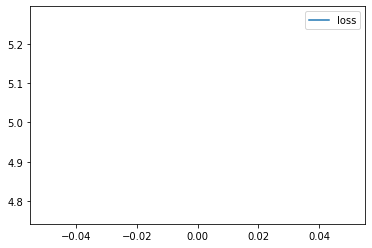

In [ ]:
RNN_cell.apply(init_weights)
train_network_RNN (RNN_cell,
                   DEVICE,
                   earthquakes_dataloader_train,
                   n_cycles=N_CYCLES,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT,
                   lr_decay=LR_DECAY
                   )

In [ ]:
os.mkdir(READY_DIR + 'Finished training')

In [ ]:
def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    prediction += mean_val.to(device)
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    if (SAVE_INFO):
        print ('ROC_AUC               =', ROC_AUC_score, file=info_file)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    if (SAVE_INFO):
        print ('Average_precision     =', AVG_precision_score, file=info_file)
        
    print ('\n=======================')
    
    for threshold in (0.2, 0.4, 0.6, 0.8):
        print ('Threshold = ', threshold)
        print ('-----------------------')
        print (my_TP_FN_FP_TN(prediction, target, threshold))
        print ('=======================')
    
    if SAVE_INFO:
        print ('\n=======================', file=info_file)
    
        for threshold in (0.2, 0.4, 0.6, 0.8):
            print ('Threshold = ', threshold                    , file=info_file)
            print ('-----------------------'                    , file=info_file)
            print (my_TP_FN_FP_TN(prediction, target, threshold), file=info_file)
            print ('======================='                    , file=info_file)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
#     precision = np.zeros(n_dots)
#     recall    = np.zeros(n_dots)
#     FPR       = np.zeros(n_dots)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '^')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_Recall_curve.png', format='png', dpi=100)
    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

In [ ]:
def print_INFO_to_file(info_file):
        
    print ('LEFT_BORDER           =', LEFT_BORDER                           , file=info_file)
    print ('RIGHT_BORDER          =', RIGHT_BORDER                          , file=info_file)
    print ('DOWN_BORDER           =', DOWN_BORDER                           , file=info_file)
    print ('UP_BORDER             =', UP_BORDER                             , file=info_file)
    print ('N_CELLS_HOR           =', N_CELLS_HOR                           , file=info_file)
    print ('N_CELLS_VER           =', N_CELLS_VER                           , file=info_file)
    print (' '                                                              , file=info_file)
    print ('OBSERVED_DAYS         =', OBSERVED_DAYS                         , file=info_file)
    print ('DAYS_TO_PREDICT_AFTER =', DAYS_TO_PREDICT_AFTER                 , file=info_file)
    print ('DAYS_TO_PREDICT_BEFOR =', DAYS_TO_PREDICT_BEFORE                , file=info_file)
    print ('TESTING_DAYS          =', TESTING_DAYS                          , file=info_file)
    print ('HEAVY_QUAKE_THRES     =', HEAVY_QUAKE_THRES                     , file=info_file)
    print ('LEARNING_RATE         =', LEARNING_RATE                         , file=info_file)
    print ('LR_DECAY              =', LR_DECAY                              , file=info_file)
    print ('N_CYCLES              =', N_CYCLES                              , file=info_file)
    print ('EARTHQUAKE_WEIGHT     =', EARTHQUAKE_WEIGHT                     , file=info_file)
    print ('TRAIN_SHAPE           =', earthquakes_dataset_train.data.shape  , file=info_file)
    print ('TEST__SHAPE           =', earthquakes_dataset_test .data.shape  , file=info_file)
    print (' '                                                              , file=info_file)
    print ('EMB_SIZE              =', EMB_SIZE                              , file=info_file)
    print ('HID_SIZE              =', HID_SIZE                              , file=info_file)
    
    
#         print ('', , file=info_file)


In [ ]:
with torch.no_grad():
    RNN_cell.eval()

    if SAVE_INFO:
        info_file = open (EXPERIMENT_DIR + 'INFO.txt', 'w')
    else:
        info_file = None

    if SAVE_INFO:
        print_INFO_to_file(info_file)

    ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                       DEVICE,
                                       earthquakes_dataloader_test,
                                       n_dots=251,
                                       info_file=info_file)

    if SAVE_INFO:
        info_file.close()
